In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [3]:
# Path ke dataset di Google Drive
sdir = '/content/drive/MyDrive/Dataset Capstone/Dataset Cabai'
filepaths = []
labels = []
classlist = os.listdir(sdir)

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())

                                           filepaths          labels
0  /content/drive/MyDrive/Dataset Capstone/Datase...  Chili__healthy
1  /content/drive/MyDrive/Dataset Capstone/Datase...  Chili__healthy
2  /content/drive/MyDrive/Dataset Capstone/Datase...  Chili__healthy
3  /content/drive/MyDrive/Dataset Capstone/Datase...  Chili__healthy
4  /content/drive/MyDrive/Dataset Capstone/Datase...  Chili__healthy
labels
Chili__healthy      100
Chili__leaf curl     88
Chili__leaf spot     88
Chili__whitefly      85
Chili__yellowish     81
Name: count, dtype: int64


In [4]:
# Direktori data
train_dir = '/content/drive/MyDrive/Dataset Capstone/Augmented Dataset'
validation_dir = '/content/drive/MyDrive/Dataset Capstone/Dataset Cabai'

# ImageDataGenerator untuk training dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk validasi tanpa augmentasi
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow dari direktori untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Flow dari direktori untuk validasi
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 812 images belonging to 5 classes.
Found 442 images belonging to 5 classes.


## Create Model With VGG16

In [5]:
# Memuat model VGG16 yang telah dilatih sebelumnya tanpa termasuk top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Membekukan layer-layer dari VGG16 agar tidak dilatih ulang
for layer in base_model.layers:
    layer.trainable = False

# Menambahkan lapisan custom di atas VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # Sesuaikan dengan jumlah kelas penyakit

# Membuat model baru
model = Model(inputs=base_model.input, outputs=predictions)

# Mengompilasi model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [6]:
# Melatih Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/150
25/25 [==============================] - 375s 15s/step - loss: 1.9380 - accuracy: 0.3744 - val_loss: 0.9526 - val_accuracy: 0.6082
Epoch 2/150
25/25 [==============================] - 11s 443ms/step - loss: 1.1212 - accuracy: 0.5372 - val_loss: 0.9766 - val_accuracy: 0.5889
Epoch 3/150
25/25 [==============================] - 10s 382ms/step - loss: 0.9978 - accuracy: 0.5949 - val_loss: 0.8447 - val_accuracy: 0.6130
Epoch 4/150
25/25 [==============================] - 9s 376ms/step - loss: 0.9737 - accuracy: 0.6090 - val_loss: 0.7700 - val_accuracy: 0.6971
Epoch 5/150
25/25 [==============================] - 10s 410ms/step - loss: 0.8472 - accuracy: 0.6782 - val_loss: 0.6886 - val_accuracy: 0.7452
Epoch 6/150
25/25 [==============================] - 10s 398ms/step - loss: 0.8562 - accuracy: 0.6551 - val_loss: 0.6145 - val_accuracy: 0.7692
Epoch 7/150
25/25 [==============================] - 10s 389ms/step - loss: 0.7904 - accuracy: 0.7013 - val_loss: 0.6492 - val_accuracy: 0

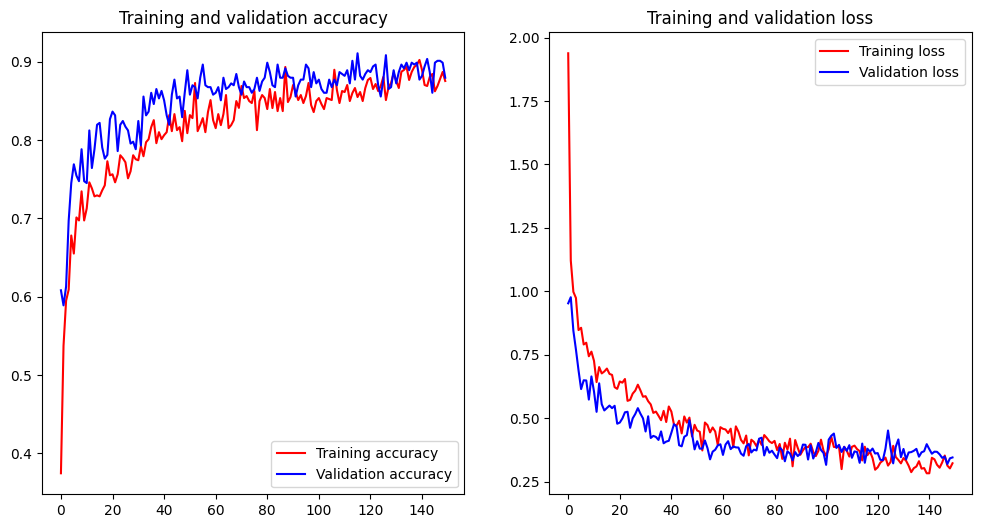

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')

plt.show()

14/14 [==============================] - 5s 366ms/step


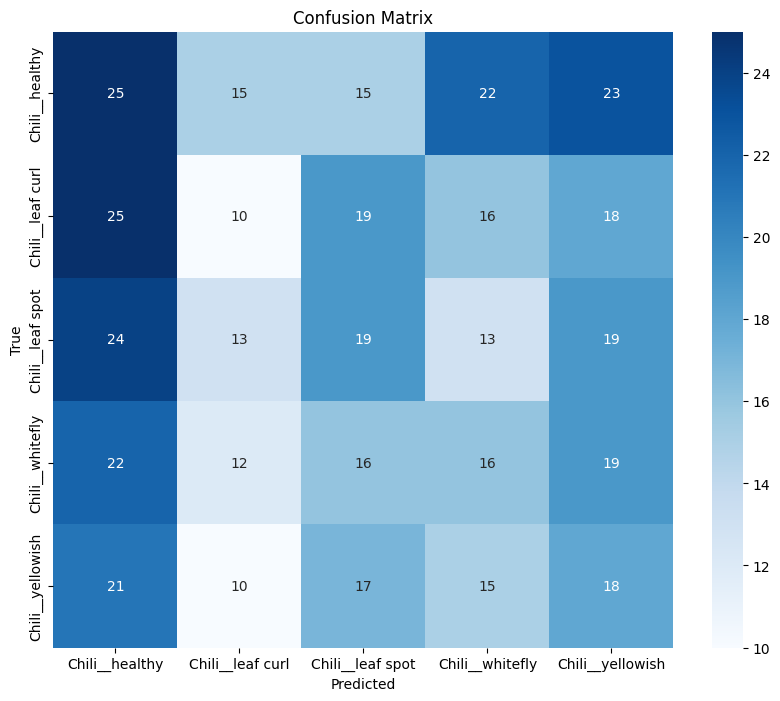

Classification Report
                  precision    recall  f1-score   support

  Chili__healthy       0.21      0.25      0.23       100
Chili__leaf curl       0.17      0.11      0.14        88
Chili__leaf spot       0.22      0.22      0.22        88
 Chili__whitefly       0.20      0.19      0.19        85
Chili__yellowish       0.19      0.22      0.20        81

        accuracy                           0.20       442
       macro avg       0.20      0.20      0.20       442
    weighted avg       0.20      0.20      0.20       442



In [8]:
# Mengambil prediksi dari model
Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Mengambil label asli dari generator
y_true = validation_generator.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

In [ ]:
# Menyimpan model ke dalam format HDF5
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

# Menyimpan arsitektur model ke dalam format JSON
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
import tensorflow as tf

# Mengonversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model ke dalam format TensorFlow Lite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)